# CIFAR-10

## Importing Required Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import applications

from sklearn.metrics import confusion_matrix, classification_report

from keras.models import Sequential
from keras.layers import MaxPooling2D, Conv2D, Flatten, Dense, Activation, Dropout

import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

## Loading the Data

(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

## Ploting - CIFAR-10 dataset

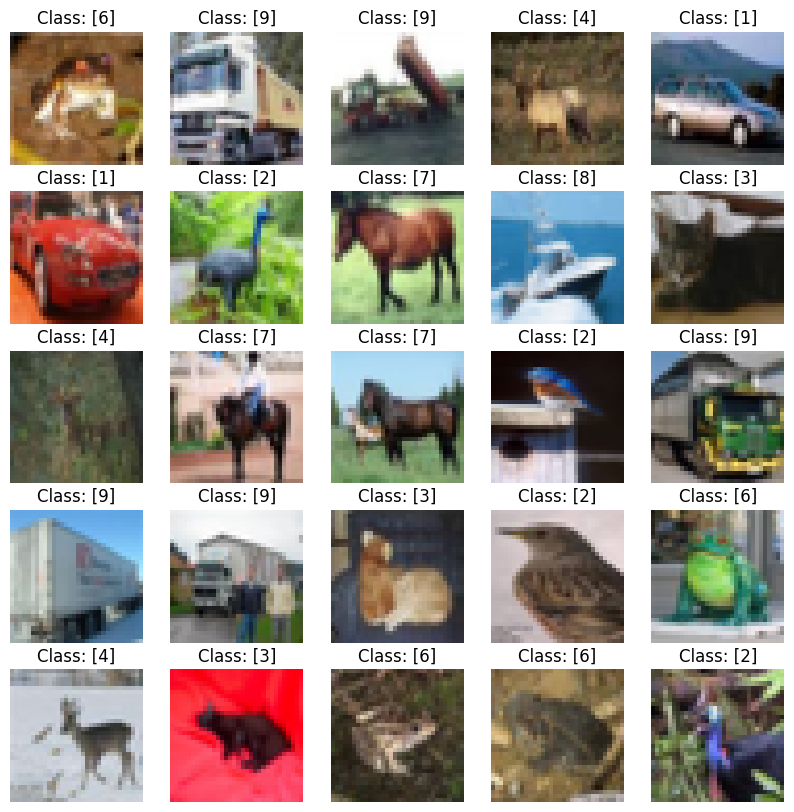

In [3]:

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X_train[i])
    plt.title(f'Class: {y_train[i]}')
    plt.axis('off')
plt.show()

[9]


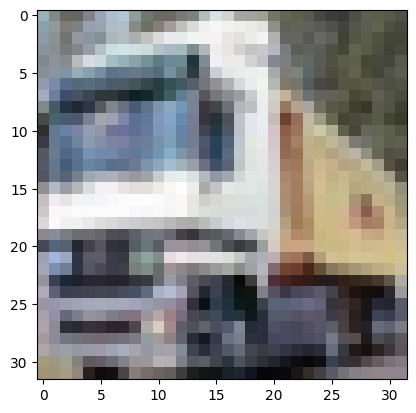

In [4]:
print(y_train[1])
plt.imshow(X_train[1]);

## Data Augmentation

In [5]:
data_augmentation = keras.Sequential([layers.RandomFlip("horizontal"),keras.layers.RandomRotation(factor=0.2),
                                      layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
                                      layers.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3)),
                                      layers.RandomBrightness(factor=0.1),
                                      layers.RandomContrast(factor=0.1)])

## Building the Model

In [6]:
from tensorflow.keras import layers, models

inputs = layers.Input((32, 32, 3))

x = layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="same")(inputs)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.MaxPooling2D(pool_size=2, strides=2)(x)

x = layers.Conv2D(filters=64, kernel_size=3, strides=1, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters=64, kernel_size=3, strides=1, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.MaxPooling2D(pool_size=2, strides=2)(x)

x = layers.Flatten()(x)
x = layers.Dense(128)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Dropout(rate=0.5)(x)

outputs = layers.Dense(10, activation='softmax')(x)

model = models.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                             

## Custom Keras Callback for Getting Best Model Weights

In [7]:
class GetBestModel(keras.callbacks.Callback):
    def __init__(self, monitor = "val_loss", verbose = 0, mode = "auto"):
        super(GetBestModel, self).__init__()
        self.monitor = monitor
        self.verbose = verbose
        self.mode = mode
        if self.mode == "min":
            self.best = np.Inf
        else:
            self.best = -np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if self.mode == "min" and current < self.best:
            self.best = current
            self.best_weights = self.model.get_weights()
        elif self.mode == "max" and current > self.best:
            self.best = current
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs=None):
        self.model.set_weights(self.best_weights)

In [8]:
best_model = GetBestModel(monitor = "val_loss", mode = "min", verbose = 1)
early_stop = keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 10)

## Compiling and Training the Model

In [9]:
model.compile(optimizer = optimizers.Adam(learning_rate = 0.001), loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])
history = model.fit(X_train, y_train, epochs = 10, validation_data = (X_test, y_test), callbacks = [early_stop, best_model])

Epoch 1/10
1563/1563 [==============================] - 265s 168ms/step - loss: 1.2952 - accuracy: 0.5450 - val_loss: 1.0365 - val_accuracy: 0.6222
Epoch 2/10
1563/1563 [==============================] - 279s 179ms/step - loss: 0.9152 - accuracy: 0.6830 - val_loss: 0.8800 - val_accuracy: 0.6865
Epoch 3/10
1563/1563 [==============================] - 267s 171ms/step - loss: 0.7911 - accuracy: 0.7228 - val_loss: 0.8488 - val_accuracy: 0.7031
Epoch 4/10
1563/1563 [==============================] - 257s 165ms/step - loss: 0.7071 - accuracy: 0.7548 - val_loss: 0.7317 - val_accuracy: 0.7421
Epoch 5/10
1563/1563 [==============================] - 268s 172ms/step - loss: 0.6323 - accuracy: 0.7806 - val_loss: 0.6472 - val_accuracy: 0.7766
Epoch 6/10
1563/1563 [==============================] - 253s 162ms/step - loss: 0.5690 - accuracy: 0.8016 - val_loss: 0.7251 - val_accuracy: 0.7469
Epoch 7/10
1563/1563 [==============================] - 241s 154ms/step - loss: 0.5116 - accuracy: 0.8208 - val_

## Building ResNet Model 

In [10]:
resnet = applications.ResNet50(input_shape=(32, 32, 3), include_top=False, weights=None)
x = layers.Flatten()(resnet.output)
x = layers.Dense(32)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Dropout(rate=0.5)(x)
outputs_resnet = layers.Dense(10, activation='softmax')(x)

model_resnet = models.Model(resnet.input, outputs_resnet)
model_resnet.summary()


resnet = applications.ResNet50(input_shape=(32, 32, 3), include_top=False, weights=None)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                                                                                            

                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 8, 8, 64)    256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 8, 8, 64)    0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 8, 8, 256)    16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_block3_3_bn (BatchNormal  (None, 8, 8, 256)   1024        ['conv2_block3_3_conv[0][0]']    
 ization) 

                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 4, 4, 128)   512         ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 4, 4, 128)   0           ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, 4, 4, 512)    66048       ['conv3_block3_2_relu[0][0]']    
                                                                                                  
 conv3_block3_3_bn (BatchNormal  (None, 4, 4, 512)   2048        ['conv3_block3_3_conv[0][0]']    
 ization) 

                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 2, 2, 256)   1024        ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 2, 2, 256)   0           ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_3_conv (Conv2D)   (None, 2, 2, 1024)   263168      ['conv4_block2_2_relu[0][0]']    
                                                                                                  
 conv4_block2_3_bn (BatchNormal  (None, 2, 2, 1024)  4096        ['conv4_block2_3_conv[0][0]']    
 ization) 

 n)                                                                                               
                                                                                                  
 conv4_block5_3_conv (Conv2D)   (None, 2, 2, 1024)   263168      ['conv4_block5_2_relu[0][0]']    
                                                                                                  
 conv4_block5_3_bn (BatchNormal  (None, 2, 2, 1024)  4096        ['conv4_block5_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_add (Add)         (None, 2, 2, 1024)   0           ['conv4_block4_out[0][0]',       
                                                                  'conv4_block5_3_bn[0][0]']      
                                                                                                  
 conv4_blo

 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 1, 1, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, 1, 1, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_add (Add)         (None, 1, 1, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_bn[0][0]']      
                                                                                                  
 conv5_blo

## Training ResNet Model

In [11]:
best_model_resnet = GetBestModel(monitor="val_loss", mode="min", verbose=1)
early_stop_resnet = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

model_resnet.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history_resnet = model_resnet.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), callbacks=[early_stop_resnet, best_model_resnet])

Epoch 1/10
1563/1563 [==============================] - 3497s 2s/step - loss: 1.8685 - accuracy: 0.3213 - val_loss: 2.6306 - val_accuracy: 0.2752
Epoch 2/10
1563/1563 [==============================] - 3520s 2s/step - loss: 1.5607 - accuracy: 0.4510 - val_loss: 1.4854 - val_accuracy: 0.4657
Epoch 3/10
1563/1563 [==============================] - 3427s 2s/step - loss: 1.3784 - accuracy: 0.5260 - val_loss: 2.1294 - val_accuracy: 0.3948
Epoch 4/10
1563/1563 [==============================] - 3323s 2s/step - loss: 1.2525 - accuracy: 0.5750 - val_loss: 1.3425 - val_accuracy: 0.5518
Epoch 5/10
1563/1563 [==============================] - 3201s 2s/step - loss: 1.1477 - accuracy: 0.6163 - val_loss: 1.2115 - val_accuracy: 0.6006
Epoch 6/10
1563/1563 [==============================] - 2887s 2s/step - loss: 1.0532 - accuracy: 0.6566 - val_loss: 1.3118 - val_accuracy: 0.5710
Epoch 7/10
1563/1563 [==============================] - 4193s 3s/step - loss: 0.9617 - accuracy: 0.6892 - val_loss: 1.1339 -

## Building VGG Model 

In [12]:
vgg16 = applications.VGG16(input_shape=(32, 32, 3), include_top=False, weights=None)
x = layers.Flatten()(vgg16.output)
x = layers.Dense(128)(x) 
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Dropout(rate=0.5)(x)
outputs_vgg16 = layers.Dense(10, activation='softmax')(x)

model_vgg16 = models.Model(vgg16.input, outputs_vgg16)
model_vgg16.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0   

## Training VGG16 Model 

In [13]:
best_model_vgg16 = GetBestModel(monitor="val_loss", mode="min", verbose=1)
early_stop_vgg16 = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)

model_vgg16.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history_vgg16 = model_vgg16.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), callbacks=[early_stop_vgg16, best_model_vgg16])

Epoch 1/10
1563/1563 [==============================] - 3193s 2s/step - loss: 2.0121 - accuracy: 0.2238 - val_loss: 1.6942 - val_accuracy: 0.3221
Epoch 2/10
1563/1563 [==============================] - 3226s 2s/step - loss: 1.6095 - accuracy: 0.3523 - val_loss: 1.4289 - val_accuracy: 0.4452
Epoch 3/10
1563/1563 [==============================] - 3167s 2s/step - loss: 1.3913 - accuracy: 0.4718 - val_loss: 1.2313 - val_accuracy: 0.5455
Epoch 4/10
1563/1563 [==============================] - 3169s 2s/step - loss: 1.1141 - accuracy: 0.5967 - val_loss: 0.9924 - val_accuracy: 0.6455
Epoch 5/10
1563/1563 [==============================] - 3174s 2s/step - loss: 0.9114 - accuracy: 0.6777 - val_loss: 0.8623 - val_accuracy: 0.6939
Epoch 6/10
1563/1563 [==============================] - 3174s 2s/step - loss: 0.7827 - accuracy: 0.7289 - val_loss: 0.8712 - val_accuracy: 0.7113
Epoch 7/10
1563/1563 [==============================] - 3166s 2s/step - loss: 0.6693 - accuracy: 0.7718 - val_loss: 0.7858 -

## Evaluating the Models 

313/313 [==============================] - 10s 33ms/step
CNN Confusion Matrix:
[[770   6  25  62  33   5  10  21  27  41]
 [ 10 888   0  10   2   1   5   8   3  73]
 [ 59   2 518  97 114  59  86  57   4   4]
 [  5   3  14 708  69 108  58  28   0   7]
 [  4   0  19  64 804  17  27  58   5   2]
 [  4   0   8 205  45 693   9  36   0   0]
 [  1   1  14  68  37   8 859   6   2   4]
 [  5   0   3  33  38  35   5 877   0   4]
 [ 52  24   8  32   5   3  16   9 821  30]
 [ 14  40   2  23   4   4   5  15  10 883]]


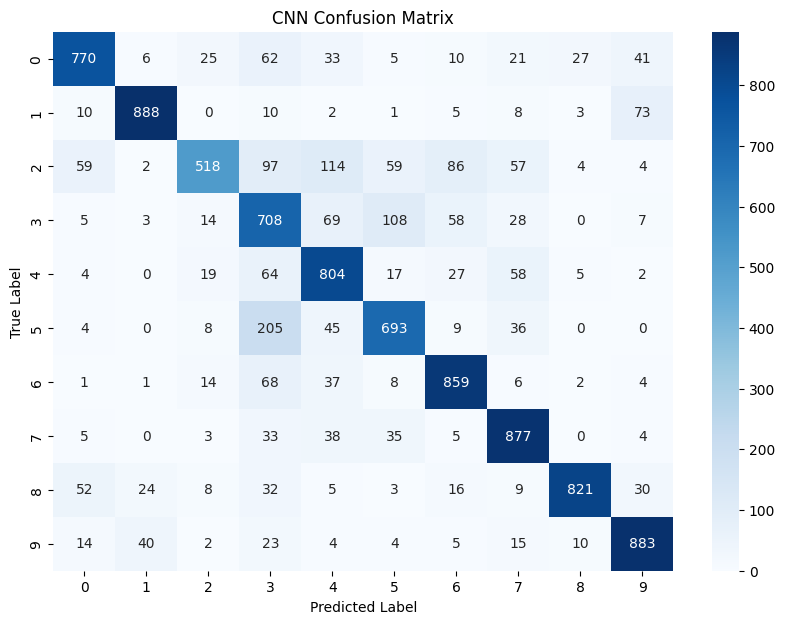

CNN Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.77      0.80      1000
           1       0.92      0.89      0.90      1000
           2       0.85      0.52      0.64      1000
           3       0.54      0.71      0.62      1000
           4       0.70      0.80      0.75      1000
           5       0.74      0.69      0.72      1000
           6       0.80      0.86      0.83      1000
           7       0.79      0.88      0.83      1000
           8       0.94      0.82      0.88      1000
           9       0.84      0.88      0.86      1000

    accuracy                           0.78     10000
   macro avg       0.80      0.78      0.78     10000
weighted avg       0.80      0.78      0.78     10000

313/313 [==============================] - 37s 115ms/step
ResNet Confusion Matrix:
[[812  10  13  14  24   3  15  16  44  49]
 [ 13 810   2   6   4   0  15   3  26 121]
 [ 85   2 511  87 110  70  75  36   6  18]
 [

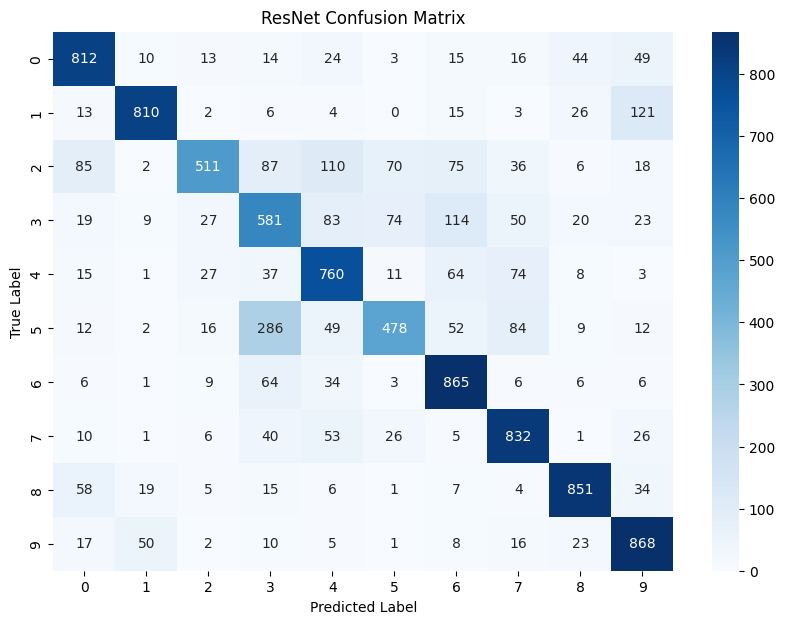

ResNet Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.81      0.79      1000
           1       0.90      0.81      0.85      1000
           2       0.83      0.51      0.63      1000
           3       0.51      0.58      0.54      1000
           4       0.67      0.76      0.71      1000
           5       0.72      0.48      0.57      1000
           6       0.71      0.86      0.78      1000
           7       0.74      0.83      0.78      1000
           8       0.86      0.85      0.85      1000
           9       0.75      0.87      0.80      1000

    accuracy                           0.74     10000
   macro avg       0.75      0.74      0.73     10000
weighted avg       0.75      0.74      0.73     10000

313/313 [==============================] - 64s 203ms/step
VGG16 Confusion Matrix:
[[863   8  15  21   8   0   3  18  19  45]
 [  4 902   0  13   0   1   2   1   8  69]
 [ 97   1 458 134 137  55  74  33   3   8]


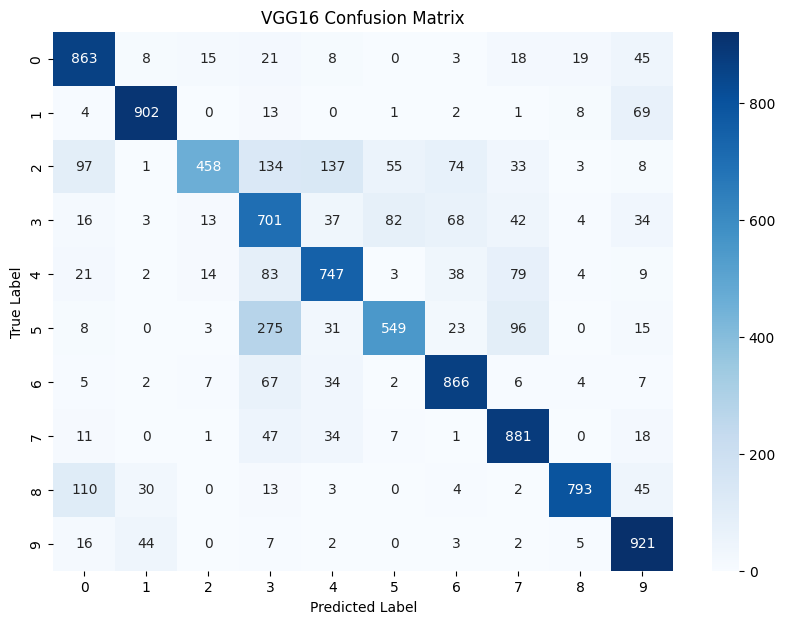

VGG16 Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.86      0.80      1000
           1       0.91      0.90      0.91      1000
           2       0.90      0.46      0.61      1000
           3       0.52      0.70      0.59      1000
           4       0.72      0.75      0.73      1000
           5       0.79      0.55      0.65      1000
           6       0.80      0.87      0.83      1000
           7       0.76      0.88      0.82      1000
           8       0.94      0.79      0.86      1000
           9       0.79      0.92      0.85      1000

    accuracy                           0.77     10000
   macro avg       0.79      0.77      0.76     10000
weighted avg       0.79      0.77      0.76     10000



In [17]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Define a function to evaluate a model
def evaluate_model(model, X_test, y_test):
    # Make predictions
    y_pred = model.predict(X_test)
    # Convert predictions to class labels
    y_pred_classes = np.argmax(y_pred, axis=1)
    # Convert true labels to class labels
    y_true_classes = np.squeeze(y_test)
    # Calculate confusion matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    # Generate classification report
    cr = classification_report(y_true_classes, y_pred_classes)
    return cm, cr

# Evaluate CNN model
cm_cnn, cr_cnn = evaluate_model(model, X_test, y_test)
print("CNN Confusion Matrix:")
print(cm_cnn)
# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_cnn, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('CNN Confusion Matrix')
plt.show()
print("CNN Classification Report:")
print(cr_cnn)

# Evaluate ResNet model
cm_resnet, cr_resnet = evaluate_model(model_resnet, X_test, y_test)
print("ResNet Confusion Matrix:")
print(cm_resnet)
# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_resnet, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('ResNet Confusion Matrix')
plt.show()
print("ResNet Classification Report:")
print(cr_resnet)

# Evaluate VGG16 model
cm_vgg16, cr_vgg16 = evaluate_model(model_vgg16, X_test, y_test)
print("VGG16 Confusion Matrix:")
print(cm_vgg16)
# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_vgg16, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('VGG16 Confusion Matrix')
plt.show()
print("VGG16 Classification Report:")
print(cr_vgg16)